### Random Walk
1. 문제: 이전에 보았던 Random walk 예시와 동일하게 왼쪽, 오른쪽에 도착지점이 있고 도달하면 끝나는 문제이다. Value function을 구한다.
2. 조건
    - state: 1~1000 사이의 값 
    - action: 오른쪽, 왼쪽 이동 (무작위로 1~100 만큼 이동한다.)
    - reward: 오른쪽 끝(+1), 왼쪽 끝(-1)
    - terminal
        - 오른쪽 끝: 1001
        - 왼쪽 끝: 0
    - policy: 
        - 무작위로 오른쪽/왼쪽을 결정한다.
3. 학습 목표
    - Value Function Approximation 
        - State Aggregation
        - Tile Coding
    - Gradient Monte-Carlo Algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
true_value = np.arange(-1001, 1003, 2) / 1001.0
START = 500
END = [0, 1001]
LEFT, RIGHT = -1, 1
ACTIONS = [LEFT, RIGHT]
STEP_RANGE = 100
N_STATES = 1000

class RandomWalk:
    
    def __init__(self):
        self.reset()

    def step(self, action):
        done = False
        step = np.random.randint(1, STEP_RANGE + 1)
        step *= action
        self.state += step
        self.state = max(min(self.state, N_STATES + 1), 0)
        if self.state == 0:
            reward = -1
            done = True
        elif self.state == N_STATES + 1:
            reward = 1
            done = True
        else:
            reward = 0
        return self.state, reward, done 
    
    def reset(self):
        self.state = START
        return self.state

### Value Function Approximation
value function을 $\hat v(S_t, \textbf{w}_t$로 근사해서 구한다. 각각의 state는 ***state aggregation***을 사용해서 일정 구간 별로 묶어서 작게 나타냈다. (이 문제에서는 1000개라서 쪼개지 않아도 상관없지만 continuous하다고 생각했을 땐 discrete로 쪼개서 생각하는 것이 편리하다.)

parameter를 update할 때 구해야 하는 항인 gradient $\nabla \hat v (S_t, \textbf{w})$는 전체 state에 대한 $t$에서 state의 indicator function이 된다. (1, 0)
![mc gradient](../images/gradient_MC.png)

In [4]:
class ValueFunction:
    
    def __init__(self, num_groups):
        self.num_groups = num_groups
        self.group_size = N_STATES // num_groups
        self.params = np.zeros(num_groups)

    def value(self, state):
        if state in END:
            return 0
        group_idx = (state - 1) // self.group_size
        return self.params[group_idx]

    def update(self, delta, state):
        group_idx = (state - 1) // self.group_size
        self.params[group_idx] += delta

### Tile Coding
Randomwalk environment를 일정한 너비로 state aggregation을 해서 tile을 만든다. 같은 방법으로 일정한 offset을 줘서 약간 어긋나서 겹치게 여러 장을 만든다. 이렇게 만들어진 각각의 장에 대해서 tile에 대한 weight를 지정해준다. 

맨 처음 장에 대해서 각 tile을 보면 뒤에 다른 장들의 어떤 tile이 매칭이 되는지 확인할 수 있다. 포함되는 여러 장의 모든 tile을 고려해서 value function을 구하고, 각각의 weight를 update해준다.

local 구간(receptive field)에 대한 정보를 나눈 뒤 이를 조합하는데 그 때 각각의 가중치를 학습시켜서 어떤 정보끼리가 중요한지 알아가는 과정이라고 보면 되겠다.

In [104]:
class TilingsValueFunction:
    # @numOfTilings: # of tilings
    # @tileWidth: each tiling has several tiles, this parameter specifies the width of each tile
    # @tilingOffset: specifies how tilings are put together
    def __init__(self, num_tilings, tile_width, tiling_offset):
        self.num_tilings = num_tilings
        self.tile_width = tile_width
        self.tiling_offset = tiling_offset

        # To make sure that each sate is covered by same number of tiles,
        # we need one more tile for each tiling
        self.tiling_size = N_STATES // tile_width + 1

        # weight for each tile
        self.params = np.zeros((self.num_tilings, self.tiling_size))

        # For performance, only track the starting position for each tiling
        # As we have one more tile for each tiling, the starting position will be negative
        self.tilings = np.arange(-tile_width + 1, 0, tiling_offset)

    # get the value of @state
    def value(self, state):
        state_value = 0.0
        # go through all the tilings
        for tiling_index in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tile_index = (state - self.tilings[tiling_index]) // self.tile_width
            state_value += self.params[tiling_index, tile_index]
        return state_value

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):

        # each state is covered by same number of tilings
        # so the delta should be divided equally into each tiling (tile)
        delta /= self.num_tilings

        # go through all the tilings
        for tiling_index in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tile_index = (state - self.tilings[tiling_index]) // self.tile_width
            self.params[tiling_index, tile_index] += delta

In [105]:
def gradient_mc(env, value_fn, policy_fn, alpha, distribution=None):
    episode = []
    state = env.reset()
    while True:
        action = ACTIONS[policy_fn()]
        next_state, reward, done = env.step(action)
        episode.append([state, action, reward])            
        state = next_state
        if done:
            break
    for t, (state, action, reward) in enumerate(episode):
        G = sum([x[2] for x in episode[t:]])
        delta = alpha * (G - value_fn.value(state))                
        value_fn.update(delta, state)
        if distribution is not None:
            distribution[state] += 1

### Figure 9.1

**state aggregation**으로 state를 근사해서 단순하게 나타냈을 때 true value에 얼마나 가깝게 학습하는 지를 보여준다.

In [106]:
num_episodes = 10000
env = RandomWalk()
policy = lambda: np.random.binomial(1, 0.5)
value_fn = ValueFunction(10)
distribution = np.zeros([N_STATES + 1])
for i_episode in range(num_episodes):
    gradient_mc(env, value_fn, policy, 2e-5, distribution)

In [107]:
estimated_value = [value_fn.value(s) for s in range(1, N_STATES+1)]
distribution /= N_STATES

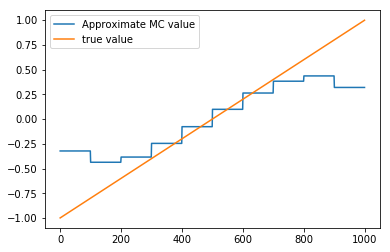

In [108]:
plt.plot(estimated_value, label='Approximate MC value')
plt.plot(true_value[1:-1], label='true value')
plt.legend()
plt.show()

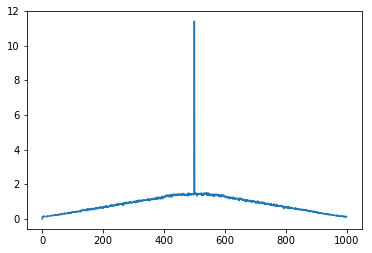

In [109]:
plt.plot(distribution)
plt.show()

### Figure 9.10

value function을 state aggregation, tile coding으로 근사했을 때의 *Mean Squared Value Error($\bar {VE}$)*를 비교해본다.

In [125]:
num_episodes = 5000
env = RandomWalk()
policy = lambda: np.random.binomial(1, 0.5)
value_fn = TilingsValueFunction(50, 200, 4)
errors = []
for i_episode in range(1, num_episodes + 1):
    alpha = 1.0 / (i_episode + 1)
    gradient_mc(env, value_fn, policy, alpha)
    error = np.sqrt(np.sum(np.square(true_value[1: -1] - np.array([value_fn.value(s) for s in range(1, N_STATES+1)]))))
    errors.append(error)

In [126]:
estimated_value = [value_fn.value(s) for s in range(1, N_STATES + 1)]

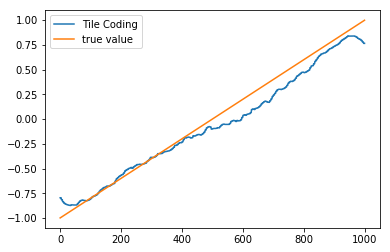

In [127]:
plt.plot(estimated_value, label='Tile Coding')
plt.plot(true_value[1:-1], label='true value')
plt.legend()
plt.show()

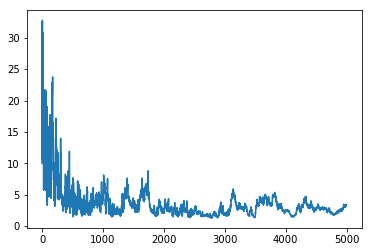

In [128]:
plt.plot(range(1, num_episodes+1), errors)
plt.show()